Let's look at:
Number of labels per image (histogram)
Quality score per image for images with multiple labels (sigmoid?)


In [4]:
import csv
from itertools import islice
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
import numpy as np

In [5]:
CSV_PATH = 'wgangp_data.csv'

In [6]:
realness = {}
# real_votes = defaultdict(int)
# fake_votes = defaultdict(int)
total_votes = defaultdict(int)
correct_votes = defaultdict(int)




with open(CSV_PATH) as f:
    dictreader = csv.DictReader(f)
    for line in dictreader:
        img_name = line['img']
        assert(line['realness'] in ('True', 'False'))
        assert(line['correctness'] in ('True', 'False'))
        
        realness[img_name] = line['realness'] == 'True'
        if line['correctness'] == 'True':
            correct_votes[img_name] += 1
        total_votes[img_name] += 1
        
        

In [7]:
pdx = pd.read_csv(CSV_PATH)
pdx

,Unnamed: 0,correctness,img,realness,session_id,task_name,timestep,worker_id
0,116057,True,celeba500/005077_crop.jpg,True,7395,wgangp-inf,100,A1G42P7S1ROOD2
1,116058,True,wgangp5000/wgan_gp_29621.png,False,7395,wgangp-inf,101,A1G42P7S1ROOD2
2,116059,False,celeba500/003661_crop.jpg,True,7395,wgangp-inf,102,A1G42P7S1ROOD2
3,116060,False,celeba500/003470_crop.jpg,True,7395,wgangp-inf,103,A1G42P7S1ROOD2
4,116061,True,celeba500/004947_crop.jpg,True,7395,wgangp-inf,104,A1G42P7S1ROOD2
5,116062,True,wgangp5000/wgan_gp_30515.png,False,7395,wgangp-inf,105,A1G42P7S1ROOD2
6,116063,True,wgangp5000/wgan_gp_42791.png,False,7395,wgangp-inf,106,A1G42P7S1ROOD2
7,116064,True,celeba500/003585_crop.jpg,True,7395,wgangp-inf,107,A1G42P7S1ROOD2
8,116065,True,celeba500/005562_crop.jpg,True,7395,wgangp-inf,108,A1G42P7S1ROOD2
9,116066,True,wgangp5000/wgan_gp_17505.png,False,7395,wgangp-inf,109,A1G42P7S1ROOD2


In [8]:
pdx[pdx.groupby('img').count() > 50]
pdx
#df.img
# print(df.columns)
# print(df['img'])

,Unnamed: 0,correctness,img,realness,session_id,task_name,timestep,worker_id
0,116057,True,celeba500/005077_crop.jpg,True,7395,wgangp-inf,100,A1G42P7S1ROOD2
1,116058,True,wgangp5000/wgan_gp_29621.png,False,7395,wgangp-inf,101,A1G42P7S1ROOD2
2,116059,False,celeba500/003661_crop.jpg,True,7395,wgangp-inf,102,A1G42P7S1ROOD2
3,116060,False,celeba500/003470_crop.jpg,True,7395,wgangp-inf,103,A1G42P7S1ROOD2
4,116061,True,celeba500/004947_crop.jpg,True,7395,wgangp-inf,104,A1G42P7S1ROOD2
5,116062,True,wgangp5000/wgan_gp_30515.png,False,7395,wgangp-inf,105,A1G42P7S1ROOD2
6,116063,True,wgangp5000/wgan_gp_42791.png,False,7395,wgangp-inf,106,A1G42P7S1ROOD2
7,116064,True,celeba500/003585_crop.jpg,True,7395,wgangp-inf,107,A1G42P7S1ROOD2
8,116065,True,celeba500/005562_crop.jpg,True,7395,wgangp-inf,108,A1G42P7S1ROOD2
9,116066,True,wgangp5000/wgan_gp_17505.png,False,7395,wgangp-inf,109,A1G42P7S1ROOD2


In [10]:
# How much of the time do people guess "fake"? Slightly more than half!
pdx[pdx.correctness != pdx.realness].count()/pdx.count()

Unnamed: 0     0.539928
correctness    0.539928
img            0.539928
realness       0.539928
session_id     0.539928
task_name      0.539928
timestep       0.539928
worker_id      0.539928
dtype: float64

In [12]:
# How much of the time do people guess right? 94.4%
pdx[pdx.correctness].count()/pdx.count()

Unnamed: 0     0.944071
correctness    0.944071
img            0.944071
realness       0.944071
session_id     0.944071
task_name      0.944071
timestep       0.944071
worker_id      0.944071
dtype: float64

In [15]:
#90.3% of the time, real images are correctly labeled as real
pdx[pdx.realness][pdx.correctness].count()/pdx[pdx.realness].count()

/Users/alexkolchinski/anaconda3/envs/wgan_experiment/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


Unnamed: 0     0.903298
correctness    0.903298
img            0.903298
realness       0.903298
session_id     0.903298
task_name      0.903298
timestep       0.903298
worker_id      0.903298
dtype: float64

In [18]:
#98.5% of the time, fake images are correctly labeled as fake
pdx[~pdx.realness][pdx.correctness].count()/pdx[~pdx.realness].count()

/Users/alexkolchinski/anaconda3/envs/wgan_experiment/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Unnamed: 0     0.985014
correctness    0.985014
img            0.985014
realness       0.985014
session_id     0.985014
task_name      0.985014
timestep       0.985014
worker_id      0.985014
dtype: float64

In [19]:
len(total_votes.values())

4301

(array([ 1.,  0.,  1.,  1.,  2.,  4.,  6.,  9., 11., 15.]),
 array([0.62043796, 0.65764789, 0.69485783, 0.73206776, 0.7692777 ,
        0.80648763, 0.84369757, 0.88090751, 0.91811744, 0.95532738,
        0.99253731]),
 <a list of 10 Patch objects>)

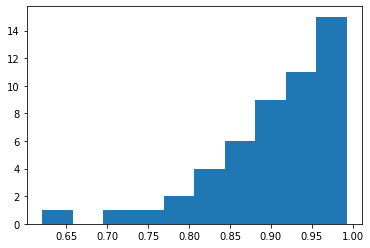

In [24]:
img_dict = {img: [realness[img],  correct_votes[img], total_votes[img], correct_votes[img]/total_votes[img]] for img in realness }
# print(img_dict.keys())
#img_dict['celeba500/005077_crop.jpg']
plt.hist([v[3] for k,v in img_dict.items() if 'celeb' in k])

In [124]:
def getVotesDict(img_dict):

    votes_dict = defaultdict(int)
    for img in total_votes:
        votes_dict[img_dict[img][2]] += 1
    return votes_dict
    
votes_dict = getVotesDict(img_dict)
for i in sorted(votes_dict.keys()):
    print(i, votes_dict[i])

1 2460
2 1283
3 400
4 95
5 11
6 2
129 2
130 1
131 4
132 4
133 8
134 8
135 10
136 8
137 3
138 2


In [140]:
selected_img_dict = {img:value for img, value in img_dict.items() if img_dict[img][2] > 10}
less_than_50_dict = {img:value for img, value in img_dict.items() if img_dict[img][2] < 10}
imgs_over_50 = list(selected_img_dict.keys())
# print(len(selected_img_dict))
# print(imgs_over_50)

In [122]:
pdx_50 = pdx[pdx.img.apply(lambda x: x  in imgs_over_50)]
len(pdx_50)

6701

In [121]:
pdx_under_50 = pdx[pdx.img.apply(lambda x: x not in imgs_over_50)]
len(pdx_under_50)

6673

In [137]:
len(pdx_under_50[pdx_under_50.img.apply(lambda x: 'wgan' not in x)])

0

[0.6204379562043796, 0.7164179104477612, 0.7557251908396947, 0.7898550724637681, 0.8059701492537313, 0.8120300751879699, 0.8248175182481752, 0.8283582089552238, 0.837037037037037, 0.8449612403100775, 0.8455882352941176, 0.8712121212121212, 0.875, 0.8787878787878788, 0.8805970149253731, 0.8823529411764706, 0.8897058823529411, 0.8962962962962963, 0.9, 0.9022556390977443, 0.9083969465648855, 0.9097744360902256, 0.9111111111111111, 0.9130434782608695, 0.9197080291970803, 0.924812030075188, 0.924812030075188, 0.9259259259259259, 0.9259259259259259, 0.9312977099236641, 0.937984496124031, 0.9398496240601504, 0.9473684210526315, 0.9481481481481482, 0.9552238805970149, 0.9555555555555556, 0.9558823529411765, 0.9618320610687023, 0.9621212121212122, 0.9701492537313433, 0.9701492537313433, 0.9703703703703703, 0.9703703703703703, 0.9703703703703703, 0.9779411764705882, 0.9779411764705882, 0.9848484848484849, 0.9849624060150376, 0.9852941176470589, 0.9925373134328358]


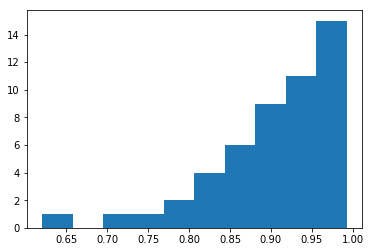

In [114]:
correctness = sorted([value[3]  for key, value in selected_img_dict.items()])
print(correctness)
plt.hist(correctness)
plt.show()

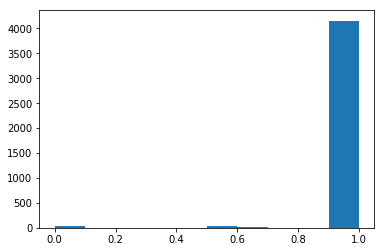

In [142]:
correctness = sorted([value[3]  for key, value in less_than_50_dict.items()])
# print(correctness)
plt.hist(correctness)
plt.show()



In [ ]:
ct = []
# selected_img = [img in total_votes.keys() if total_votes[img] > 1 ]

In [160]:
discriminator = torch.load('discriminator.pt', map_location='cpu')
# torch.load_state_dict('discriminator.pt')

In [167]:
discriminator(torch.zeros(64,64,3))

AttributeError: 'Conv2d' object has no attribute 'padding_mode'